In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.models import Model
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.optimizers import RMSprop,Adam
import tensorflow as tf
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, roc_auc_score, auc
from PIL import Image
import os
import cv2

Les données consistent en des images de visages en niveaux de gris de 48 x 48 pixels. Les visages ont été automatiquement enregistrés de manière à ce que le visage soit plus ou moins centré et occupe à peu près le même espace dans chaque image. La tâche consiste à classer chaque visage en fonction de l'émotion montrée dans l'expression faciale dans l'une des sept catégories (0 = En colère , 1 = Dégoût, 2 = Peur, 3 = Heureux, 4 = Triste, 5 = Surprise, 6 = Neutre. ) .

train.csv contient deux colonnes, "émotion" et "pixels". La colonne « émotion » contient un code numérique allant de 0 à 6 inclus pour l'émotion présente dans l'image. La colonne "pixels" contient une chaîne entourée de guillemets pour chaque image. Le contenu de cette chaîne contient des valeurs de pixels séparés par des espaces dans l'ordre principal des lignes. test.csv contient uniquement la colonne "pixels" et votre tâche consiste à prédire la colonne d'émotion.

# Importation des données

In [96]:
df =pd.read_csv(r"C:\Users\nico_\Desktop\facial_expression\fer2013\fer2013.csv")

In [97]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [98]:
df["Usage"].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

# Train and Test

In [99]:
df_train = df[df["Usage"] == "Training"]
df_test = df[df["Usage"] == "PublicTest"]

df_train = df_train[["emotion","pixels"]]
df_test = df_test[["emotion","pixels"]]

# Train

In [100]:
df_train["emotion"].value_counts()

emotion
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: count, dtype: int64

# Conversion des listes de pixels en tableaux numpy et aplatissement en vecteurs de pixels

In [101]:
# Convertir les listes de pixels en tableaux numpy et les aplatir en vecteurs de pixels
train_image_array = []
for i, row in enumerate(df_train.index):
    image = np.fromstring(df_train.loc[row, 'pixels'], dtype=int, sep=' ')
    train_image_array.append(np.reshape(image, (48 * 48)))

In [102]:
train_images_flat = np.array(train_image_array)

In [103]:
train_images_flat.shape

(28709, 2304)

# SMOTE (Synthetic Minority Over-sampling Technique) est une technique populaire de sur-échantillonnage qui vise à équilibrer les classes en créant des exemples synthétiques pour les classes sous-représentées

In [104]:
from imblearn.over_sampling import SMOTE

In [105]:
train_labels = df_train["emotion"]

In [106]:
smote = SMOTE(sampling_strategy='auto')
train_images_resampled, train_labels_resampled = smote.fit_resample(train_images_flat, train_labels)

In [107]:
train_images_resampled.shape

(50505, 2304)

# Remodelage des vecteurs aplatis en images de dimension (nombre_d'images, 48, 48, 1) pour être utiliser en entrée du modèle

In [108]:
# Remodeler les vecteurs aplaties en images de leur forme d'origine
train_images_resampled = train_images_resampled.reshape(-1, 48, 48, 1)

In [109]:
train_images_resampled.shape

(50505, 48, 48, 1)

# Répartition des classes

In [110]:
labels = ['colère','Dégoût','Peur','Heureux','Triste','Surprise','Neutre']

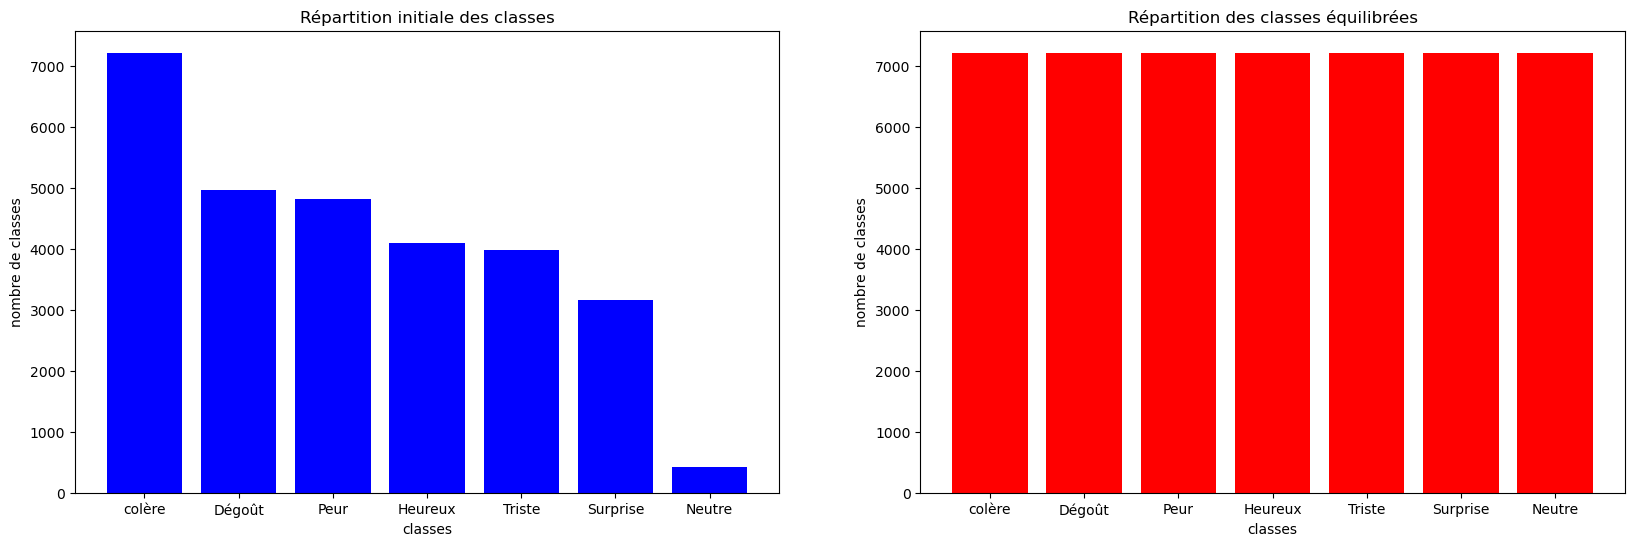

In [111]:
fig, axs = plt.subplots(1,2,figsize=(20,6))

# plot initial
axs[0].bar(x=labels, height=df_train["emotion"].value_counts(), color='blue')
axs[0].set_title("Répartition initiale des classes")
axs[0].set_xlabel("classes")
axs[0].set_ylabel("nombre de classes")

# plot avec classes équilibrées
axs[1].bar(x=labels, height=train_labels_resampled.value_counts(), color='red')
axs[1].set_title("Répartition des classes équilibrées")
axs[1].set_xlabel("classes")
axs[1].set_ylabel("nombre de classes")

plt.show()

Nous pouvons constater que les classes ont été équilibrées

# Visualisation des 5 premières émotions avec leurs images

In [112]:
emotion_map = {0: 'En colère', 1: 'Dégoût', 2: 'Peur', 3: 'Heureux', 4: 'Triste', 5: 'Surprise', 6: 'Neutre'}

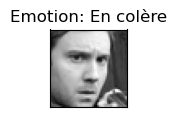

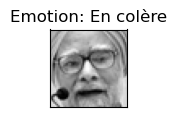

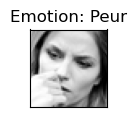

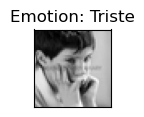

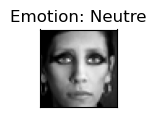

In [113]:
for i in range(5):
    image = train_images_resampled[i]
    emotion_index = train_labels_resampled[i]
    emotion = emotion_map[emotion_index]
    
    
    plt.figure(figsize=(1, 2))
    plt.imshow(train_images_resampled[i], cmap=plt.cm.gray)
    plt.title(f"Emotion: {emotion}")
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Test

In [114]:
test_images = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in df_test['pixels']])

test_images = test_images.reshape((-1, 48, 48, 1))

test_labels = np.array(df_test['emotion'])

In [115]:
test_images.shape

(3589, 48, 48, 1)

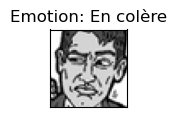

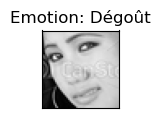

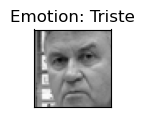

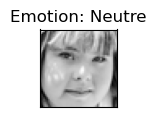

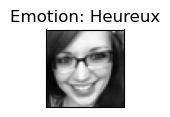

In [116]:
for i in range(5):
    image = test_images[i]
    emotion_index = test_labels[i]
    emotion = emotion_map[emotion_index]
    
    plt.figure(figsize=(1, 2))
    plt.imshow(test_images[i], cmap=plt.cm.gray)
    plt.title(f"Emotion: {emotion}")
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Recherche du learning rate optimal

In [117]:
batch_size = 64

datagen_train = ImageDataGenerator(
    rescale=1.0/255.,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

datagen_validation = ImageDataGenerator(rescale=1.0/255.)

In [118]:
train_generator = datagen_train.flow(train_images_resampled,
                                     train_labels_resampled,
                                     batch_size=batch_size,
                                     shuffle=True)

validation_generator = datagen_validation.flow(test_images,
                                               test_labels,
                                               batch_size=batch_size,
                                               shuffle=False
)

In [119]:
model2 = Sequential()

# Conv1
model2.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

# Conv2
model2.add(Conv2D(128, (3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

# Conv3
model2.add(Conv2D(512, (3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

# Conv4
model2.add(Conv2D(512, (3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

model2.add(Flatten())

model2.add(Dense(512))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.25))

model2.add(Dense(512))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.25))

model2.add(Dense(7, activation='softmax'))

model2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_78 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_78 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_78 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_53 (Conv2D)          (None, 24, 24, 128)     

In [68]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-2 * 10**(epoch / 20))

In [69]:
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model2.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,  metrics=['accuracy'])

In [70]:
epochs = 30
steps_per_epoch = train_generator.n // train_generator.batch_size
history = model2.fit(train_generator, epochs=epochs, steps_per_epoch = steps_per_epoch, callbacks=[lr_schedule])

Epoch 1/30
789/789 [==============================] - 1150s 1s/step - loss: 1.9110 - accuracy: 0.2550 - lr: 0.0100
Epoch 2/30
789/789 [==============================] - 1154s 1s/step - loss: 1.6768 - accuracy: 0.3567 - lr: 0.0112
Epoch 3/30
789/789 [==============================] - 1155s 1s/step - loss: 1.5214 - accuracy: 0.4205 - lr: 0.0126
Epoch 4/30
789/789 [==============================] - 1190s 2s/step - loss: 1.4205 - accuracy: 0.4593 - lr: 0.0141
Epoch 5/30
789/789 [==============================] - 1184s 2s/step - loss: 1.3387 - accuracy: 0.4904 - lr: 0.0158
Epoch 6/30
789/789 [==============================] - 1238s 2s/step - loss: 1.2870 - accuracy: 0.5089 - lr: 0.0178
Epoch 7/30
789/789 [==============================] - 1201s 2s/step - loss: 1.2431 - accuracy: 0.5296 - lr: 0.0200
Epoch 8/30
789/789 [==============================] - 1222s 2s/step - loss: 1.2028 - accuracy: 0.5453 - lr: 0.0224
Epoch 9/30
789/789 [==============================] - 1215s 2s/step - loss: 1.16

(0.01, 1.0, 0.0, 2.0)

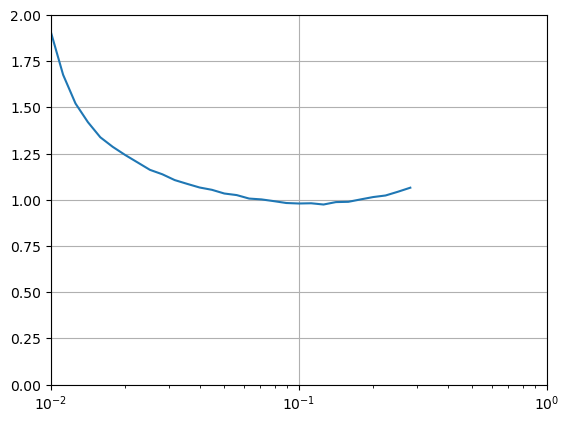

In [71]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.grid(True)
plt.axis([1e-2, 1, 0, 2])

# Loss la plus basse 

Epoch 23/30
789/789 [==============================] - 1159s 1s/step - loss: 0.9749 - accuracy: 0.6327 - lr: 0.1259

In [124]:
datagen_train = ImageDataGenerator(
    rescale=1.0/255.,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

datagen_validation = ImageDataGenerator(rescale=1.0/255.)

train_generator = datagen_train.flow(train_images_resampled,
                                     train_labels_resampled,
                                     batch_size=batch_size,
                                     shuffle=True)

validation_generator = datagen_validation.flow(test_images,
                                               test_labels,
                                               batch_size=batch_size,
                                               shuffle=False)

In [125]:
model2 = Sequential()

# Conv1
model2.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

# Conv2
model2.add(Conv2D(128, (3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

# Conv3
model2.add(Conv2D(512, (3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

# Conv4
model2.add(Conv2D(512, (3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

model2.add(Flatten())

model2.add(Dense(512))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.25))

model2.add(Dense(512))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.25))

model2.add(Dense(7, activation='softmax'))

In [126]:
epochs = 50
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

In [127]:
learning_rate = 1.259e-1
 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model2.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,  metrics=['accuracy'])
    
history = model2.fit(train_generator, epochs = epochs, steps_per_epoch = steps_per_epoch,
                    validation_data = validation_generator, validation_steps = validation_steps)

Epoch 1/50
789/789 [==============================] - 1220s 2s/step - loss: 1.9903 - accuracy: 0.2240 - val_loss: 1.7378 - val_accuracy: 0.2916
Epoch 2/50
789/789 [==============================] - 1182s 1s/step - loss: 1.7008 - accuracy: 0.3317 - val_loss: 1.6998 - val_accuracy: 0.3295
Epoch 3/50
789/789 [==============================] - 1181s 1s/step - loss: 1.5385 - accuracy: 0.4072 - val_loss: 1.8256 - val_accuracy: 0.2706
Epoch 4/50
789/789 [==============================] - 1177s 1s/step - loss: 1.4096 - accuracy: 0.4607 - val_loss: 1.4559 - val_accuracy: 0.4512
Epoch 5/50
789/789 [==============================] - 1174s 1s/step - loss: 1.3273 - accuracy: 0.4968 - val_loss: 1.3629 - val_accuracy: 0.4727
Epoch 6/50
789/789 [==============================] - 1190s 2s/step - loss: 1.2585 - accuracy: 0.5206 - val_loss: 1.4205 - val_accuracy: 0.4420
Epoch 7/50
789/789 [==============================] - 1188s 2s/step - loss: 1.2181 - accuracy: 0.5415 - val_loss: 1.2857 - val_accuracy:

Text(0.5, 1.0, 'Training and validation loss')

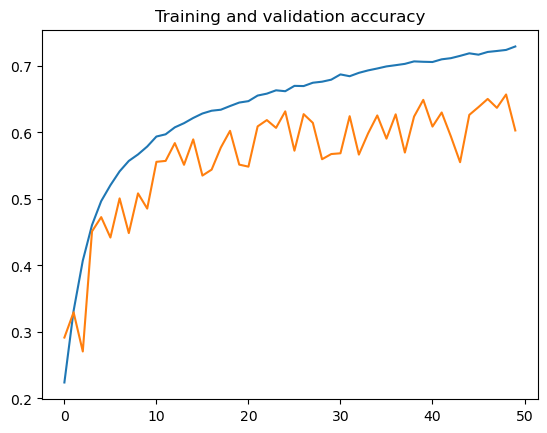

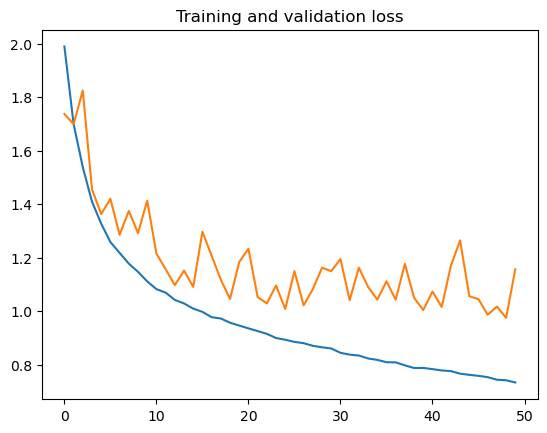

In [128]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) 

# training accuracy : blue
# validation accuracy :orange

plt.plot  ( epochs, acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()


plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss')

A partir de l'époque 30, on peut observer une légère divergence entre les performances sur l'ensemble d'entraînement et celles sur l'ensemble de validation. Cela peut indiquer un début de surapprentissage, où le modèle commence à mieux s'adapter aux données d'entraînement qu'aux nouvelles données. Cependant, cette divergence semble relativement faible et le modèle continue de généraliser raisonnablement bien sur l'ensemble de validation.

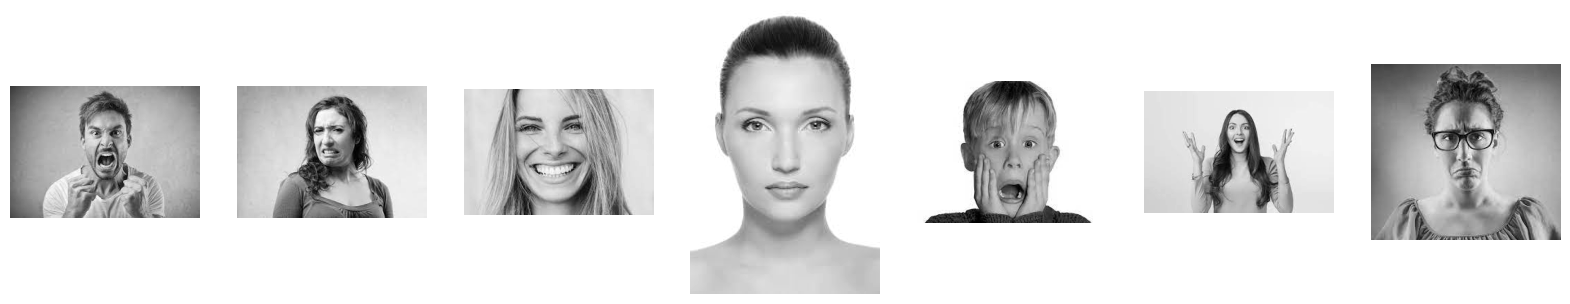

In [129]:
chemin_images = r"C:\Users\nico_\Desktop\facial_expression\images test"

chemins_images = []

for filename in os.listdir(chemin_images):
    chemin_image = os.path.join(chemin_images, filename)
    if os.path.isfile(chemin_image):
        chemins_images.append(chemin_image)

fig, axes = plt.subplots(1, len(chemins_images), figsize=(20, 5))

for i, chemin_image in enumerate(chemins_images):
    
    img = cv2.imread(chemin_image, cv2.IMREAD_GRAYSCALE)

    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')

plt.show()

In [130]:
chemin_images = r"C:\Users\nico_\Desktop\facial_expression\images test"

predictions_labels = []

for filename in os.listdir(chemin_images):
    
    chemin_image = os.path.join(chemin_images, filename)
    
    img = cv2.imread(chemin_image, cv2.IMREAD_GRAYSCALE)
    
    img_resized = cv2.resize(img, (48, 48))
    
    img_array = img_resized / 255.0
    
    img_array = np.expand_dims(img_array, axis=0)
    
    predictions = model2.predict(img_array)
    
    classe_predite = np.argmax(predictions)
    
    predictions_labels.append(classe_predite)

    
emotion_labels = {
    0: 'En colère',
    1: 'Dégoût',
    2: 'Peur',
    3: 'Heureux',
    4: 'Triste',
    5: 'Surprise',
    6: 'Neutre'
}    
    
print("Prédictions pour chaque image :")
for i, label in enumerate(predictions_labels):
    emotion = emotion_labels[label]
    print(f"Image {i+1} : Émotion prédite - {emotion}")

1/1 [==============================] - 0s 37ms/step
Prédictions pour chaque image :
Image 1 : Émotion prédite - Triste
Image 2 : Émotion prédite - Neutre
Image 3 : Émotion prédite - Heureux
Image 4 : Émotion prédite - Surprise
Image 5 : Émotion prédite - Peur
Image 6 : Émotion prédite - Neutre
Image 7 : Émotion prédite - Neutre


In [131]:
model2.save("model_lropt.h5")
model2.save('model_lropt.keras')
model_lropt_json = model2.to_json()

C:\Users\nico_\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Avec learning rate = 0.001

In [145]:
model = Sequential()

# Conv1
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv2
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv3
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv4
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

In [146]:
epochs = 100
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

learning_rate = 1e-3
 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,  metrics=['accuracy'])
    
history = model.fit(train_generator, epochs = epochs, steps_per_epoch = steps_per_epoch,
                    validation_data = validation_generator, validation_steps = validation_steps)

Epoch 1/100
789/789 [==============================] - 1245s 2s/step - loss: 2.0497 - accuracy: 0.2059 - val_loss: 2.1498 - val_accuracy: 0.0949
Epoch 2/100
789/789 [==============================] - 1241s 2s/step - loss: 1.8648 - accuracy: 0.2569 - val_loss: 2.1779 - val_accuracy: 0.1671
Epoch 3/100
789/789 [==============================] - 1239s 2s/step - loss: 1.7758 - accuracy: 0.2999 - val_loss: 1.9740 - val_accuracy: 0.2260
Epoch 4/100
789/789 [==============================] - 1238s 2s/step - loss: 1.7083 - accuracy: 0.3318 - val_loss: 2.0986 - val_accuracy: 0.2188
Epoch 5/100
789/789 [==============================] - 1247s 2s/step - loss: 1.6560 - accuracy: 0.3562 - val_loss: 1.9769 - val_accuracy: 0.2578
Epoch 6/100
789/789 [==============================] - 1243s 2s/step - loss: 1.6089 - accuracy: 0.3782 - val_loss: 1.7189 - val_accuracy: 0.3438
Epoch 7/100
789/789 [==============================] - 1292s 2s/step - loss: 1.5678 - accuracy: 0.3965 - val_loss: 2.0694 - val_ac

Text(0.5, 1.0, 'Training and validation loss')

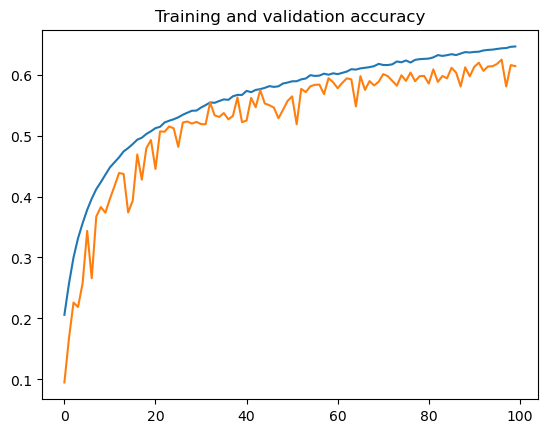

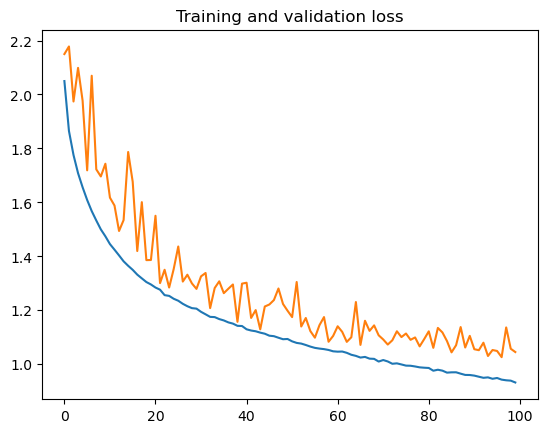

In [147]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) 

# training accuracy : blue
# validation accuracy :orange

plt.plot  ( epochs, acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()


plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss')

L'entraînement avec un taux d'apprentissage de 0.001 présente une amélioration par rapport à l'entraînement précédent avec un taux d'apprentissage optimal. Le modèle atteint une précision plus élevée sur l'ensemble de validation, même si la divergence entre l'ensemble d'entraînement et l'ensemble de validation est toujours présente, elle semble moins prononcée. Cela peut indiquer que le modèle apprend mieux avec ce taux d'apprentissage plus faible, bien qu'il soit possible que l'entraînement prenne plus de temps en raison du taux d'apprentissage plus bas.

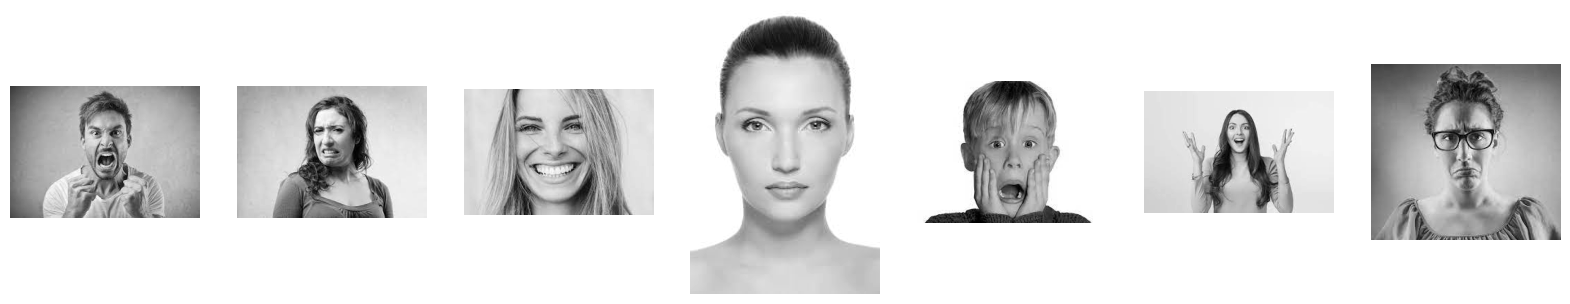

In [148]:
chemin_images = r"C:\Users\nico_\Desktop\facial_expression\images test"

chemins_images = []

for filename in os.listdir(chemin_images):
    chemin_image = os.path.join(chemin_images, filename)
    if os.path.isfile(chemin_image):
        chemins_images.append(chemin_image)

fig, axes = plt.subplots(1, len(chemins_images), figsize=(20, 5))

for i, chemin_image in enumerate(chemins_images):
    
    img = cv2.imread(chemin_image, cv2.IMREAD_GRAYSCALE)

    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')

plt.show()

In [149]:
chemin_images = r"C:\Users\nico_\Desktop\facial_expression\images test"

predictions_labels = []

for filename in os.listdir(chemin_images):
    
    chemin_image = os.path.join(chemin_images, filename)
    
    img = cv2.imread(chemin_image, cv2.IMREAD_GRAYSCALE)
    
    img_resized = cv2.resize(img, (48, 48))
    
    img_array = img_resized / 255.0
    
    img_array = np.expand_dims(img_array, axis=0)
    
    predictions = model.predict(img_array)
    
    classe_predite = np.argmax(predictions)
    
    predictions_labels.append(classe_predite)

    
emotion_labels = {
    0: 'En colère',
    1: 'Dégoût',
    2: 'Peur',
    3: 'Heureux',
    4: 'Triste',
    5: 'Surprise',
    6: 'Neutre'
}    
    
print("Prédictions pour chaque image :")
for i, label in enumerate(predictions_labels):
    emotion = emotion_labels[label]
    print(f"Image {i+1} : Émotion prédite - {emotion}")

1/1 [==============================] - 0s 47ms/step
Prédictions pour chaque image :
Image 1 : Émotion prédite - Triste
Image 2 : Émotion prédite - Triste
Image 3 : Émotion prédite - Heureux
Image 4 : Émotion prédite - Neutre
Image 5 : Émotion prédite - Peur
Image 6 : Émotion prédite - Surprise
Image 7 : Émotion prédite - Neutre


In [150]:
model.save("model_lr001.h5")
model.save('model_lr001.keras')
model_lr001_json = model.to_json()